# Counting blobs with pyclesperanto
A common use case for image processing in the biology context is counting blobs of high signal intensity surrounded by a low intensity background. Thresholding is the method of choice in this scenario. We demonstrate it with Otsu's thresholding method (Otsu et al., IEEE Transactions on Systems, Man, and Cybernetics, Vol. 9 (1), 1979)

In [1]:
import pyclesperanto_prototype as cle

from skimage.io import imread, imsave, imshow
import matplotlib
import numpy as np

# initialize GPU
cle.select_device("GTX")
print("Used GPU: " + cle.get_device().name)

Used GPU: gfx902


In [2]:
# load data
image = imread('https://samples.fiji.sc/blobs.png')
print("Loaded image size: " + str(image.shape))

# push image to GPU memory
input = cle.push(image)
print("Image size in GPU: " + str(input.shape))

Loaded image size: (254, 256)
Image size in GPU: (256, 254)


## Image processing using pyclesperanto

After initializing GPU and pushing images there, workflows are constructed like this:

c:\users\rober\miniconda3\lib\site-packages\pyopencl\__init__.py:253: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)
c:\users\rober\miniconda3\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:150: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


Number of objects in the image: 62.0


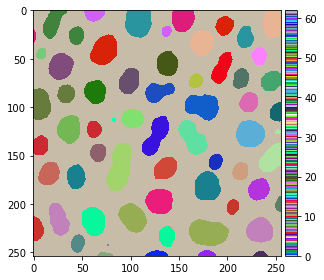

In [3]:
# process the image
blurred = cle.gaussian_blur(input, sigma_x=1, sigma_y=1)
binary = cle.threshold_otsu(blurred)
labeled = cle.connected_components_labeling_box(binary)

# show result
cmap = matplotlib.colors.ListedColormap ( np.random.rand ( 256,3))
imshow(cle.pull(labeled), cmap = cmap)

# The maxmium intensity in a label image corresponds to the number of objects
num_labels = cle.maximum_of_all_pixels(labeled)
print("Number of objects in the image: " + str(num_labels))

When processing multiple images subsequently, it might make sense to re-use memory like shown in the following. In that way, some time can be spared for not re-allocating images over and over.

Number of objects in the image: 62.0


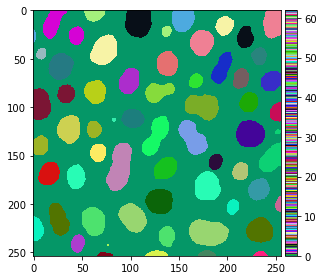

In [4]:
# process the image
blurred = cle.gaussian_blur(input, blurred, sigma_x=1, sigma_y=1)
binary = cle.threshold_otsu(blurred, binary)
labeled = cle.connected_components_labeling_box(binary, labeled)

# show result
cmap = matplotlib.colors.ListedColormap ( np.random.rand ( 256,3))
imshow(cle.pull(labeled), cmap = cmap)

# The maxmium intensity in a label image corresponds to the number of objects
num_labels = cle.maximum_of_all_pixels(labeled)
print("Number of objects in the image: " + str(num_labels))

## Addendum: Remove labels on edges
In case the size of the objects is relevant, one should exclude the object which were not fully imaged and thus, touch the image border.

[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48. 49. 50. 51. 52. 53.
 54. 55. 56. 57. 58. 59. 60. 61. 62.]
[ 0.  0.  0.  0.  0.  0.  1.  2.  3.  4.  5.  6.  7.  8.  9.  0. 10. 11.
 12. 13. 14.  0. 15. 16.  0. 17. 18. 19. 20. 21. 22. 23.  0.  0. 24. 25.
 26. 27. 28. 29. 30. 31. 32. 33. 34. 35. 36. 37.  0.  0. 38. 39. 40. 41.
 42. 43. 44. 45. 46.  0.  0.  0.  0.]
Number of objects in the image: 46.0


c:\users\rober\miniconda3\lib\site-packages\pyopencl\__init__.py:253: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


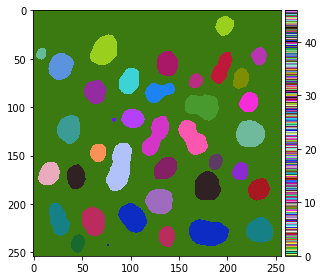

In [5]:
# Exclude Labels On Edges
labels_excl_edges = cle.exclude_labels_on_edges(labeled)

# show result
cmap = matplotlib.colors.ListedColormap ( np.random.rand ( 256,3))
imshow(cle.pull(labels_excl_edges), cmap = cmap)

# The maxmium intensity in a label image corresponds to the number of objects
num_labels = cle.maximum_of_all_pixels(labels_excl_edges)
print("Number of objects in the image: " + str(num_labels))